# ML Zoomcamp Midterm

In [201]:
import pandas as pd
import numpy as np

from pandas_profiling import ProfileReport

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, auc, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [2]:
# data from: https://www.kaggle.com/datasets/girishvutukuri/hospital-administration
raw = pd.read_csv('data/Train-1617360447408-1660719685476.csv')

## Dataset notes
Variable of interest: `readmitted`

Most variables self explanatory, except for the following:
* `X1` - `X25`: 25 features for medications, Different Medications and dosages given to the patient
  * `X1` and `X2`: "None" if no administered else the dosages
  * `X3` to `X25`: 
    * “up” if the dosage was increased during the encounter
    * “down” if the dosagewas decreased
    * “steady” if the dosage did not change
    * “no” if the drug was not prescribed
* `diag1` to `diag5`: The primary diagnosis values
* `change`: Change of medications. Indicates if there was a change in diabetic medications (either dosage or generic name). 
    * “change”
    * “no change”
* `medical_specialty`:  Medical specialty Integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values, for example, cardiology, internal medicine, family/general practice, and surgeon
* `number_outpatient`: Number of outpatient visits of the patient in the year preceding the encounter
* `diabetesMed`: Indicates if there was any diabetic medication prescribed.
  * “yes”
  * “no”

## Profiling & Data prep

In [6]:
df_pre = raw.replace('?', np.nan).drop(['index', 'patient_id', 'encounter_id'], axis=1)

In [8]:
profile = ProfileReport(df_pre, title='Profile Report')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Notes on profile

* `weight`: >98% missing mostly missing
* `race`: "Hispanic", "Other", "Asian" very small proportion
* `time_in_hospital`: right skewed
* `medical_specialty`: 50% missing
* `number_emergency`: 88% 0s
* `number_inpatient`: 66% 0s
* `number_outpatient`: 84% 0s
* `diag_X`: High cardinality (> 600)
  * `diag_5`: numeric?
* `X3`: Class imbalance, "Up", "Down" < 1000 occurrences
* `X4`: Non-"No" answers, < 1000 occurrences (drop)
* `X5`: Non-"No" answers, < 1000 occurrences (drop)
* `X6`: Non-"No" answers, < 1000 occurrences (drop)
* `X7`: "Steady", "Up", "Down" low rate - group
* `X8`: All False (drop)
* `X9`: "Steady", "Up", "Down" low rate - group
* `X10`: "Steady", "Up", "Down" low rate - group
* `X11`: Nearly all "No", (drop)
* `X12`: "Steady", "Up", "Down" low rate - group
* `X13`: "Steady", "Up", "Down" low rate - group
* `X14`: Nearly all "No", (drop)
* `X15`: Nearly all "No", (drop)
* `X16`: Nearly all "No", (drop)
* `X17`: Nearly all "No", (drop)
* `X18`: All False (drop)
* `X19`: All False (drop)
* `X21`: Nearly all "No", (drop)
* `X22`: Nearly all "No", (drop)
* `X23`: Nearly all "No", (drop)
* `X24`: Nearly all "No", (drop)
* `X25`: All False (drop)

In [72]:
# Data prep
to_drop = [
    'weight', # missing
    'diag_1', # high cardinality 
    'diag_2', # high cardinality 
    'diag_3', # high cardinality 
    'diag_4', # high cardinality 
    'diag_5', # high cardinality 
    'X4', # class imbalance
    'X5', # class imbalance
    'X6', # class imbalance
    'X8', # class imbalance
    'X11', # class imbalance
    'X14', # class imbalance
    'X15', # class imbalance
    'X16', # class imbalance
    'X17', # class imbalance
    'X18', # class imbalance
    'X19', # class imbalance
    'X21', # class imbalance
    'X22', # class imbalance
    'X23', # class imbalance
    'X24', # class imbalance
    'X25', # class imbalance

]

df = df_pre.drop(to_drop, axis=1)
nrows = len(df.index)

## Group Races
other_races = ['Hispanic', 'Other', 'Asian']

# low frequency races --> other
other_races_ix = df.race.isin(other_races)
df.race = df.race.mask(other_races_ix, 'Other')

# missing --> Caucasion
df.race = df.race.mask(df.race.isna(), 'Caucasian')

# Gender
df = df.loc[df.gender != 'Unknown/Invalid']

## Medical Specialties
# Missing as category
df.medical_specialty = df.medical_specialty.mask(df.medical_specialty.isna(), 'Missing')

# Low frequency
ms_low_freq = df.medical_specialty.value_counts(ascending=False) / nrows
ms_low_freq = ms_low_freq.loc[ms_low_freq < 0.05]
ms_low_freq = list(ms_low_freq.index)
df.medical_specialty = df.medical_specialty.mask(df.medical_specialty.isin(ms_low_freq), 'Other')

# number outpatient - recode to 0,1,2+
df.number_outpatient = df.number_outpatient.mask(df.number_outpatient >= 2, 2)

# number inpatient - recode to 0,1,2,3+
df.number_inpatient = df.number_inpatient.mask(df.number_inpatient >= 3, 3)

# number emergency - recode to 0,1,2+
df.number_emergency = df.number_emergency.mask(df.number_emergency >= 2, 2)

# X1 - recode not "None" to "Other
df.X1 = df.X1.where(df.X1 == 'None', "Other")

# X3 - recode "Up", "Down" to "Other"
df.X3 = df.X3.mask(df.X3.isin(['Up', 'Down']), "Other")

# X7 - recode not "No" to "Other"
df.X7 = df.X7.where(df.X7 == 'No', "Other")

# X9 - recode "Up", "Down" to "Other"
df.X9 = df.X9.mask(df.X9.isin(['Up', 'Down']), "Other")

# X10 - recode "Up", "Down" to "Other"
df.X10 = df.X10.mask(df.X10.isin(['Up', 'Down']), "Other")

# X12 - recode not "No" to "Other"
df.X12 = df.X12.where(df.X12 == 'No', "Other")

# X13 - recode not "No" to "Other"
df.X13 = df.X13.where(df.X13 == 'No', "Other")



### Check df prior to modeling

In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66585 entries, 0 to 66586
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   race                66585 non-null  object
 1   gender              66585 non-null  object
 2   age                 66585 non-null  object
 3   time_in_hospital    66585 non-null  int64 
 4   medical_specialty   66585 non-null  object
 5   num_lab_procedures  66585 non-null  int64 
 6   num_procedures      66585 non-null  int64 
 7   num_medications     66585 non-null  int64 
 8   number_outpatient   66585 non-null  int64 
 9   number_emergency    66585 non-null  int64 
 10  number_inpatient    66585 non-null  int64 
 11  number_diagnoses    66585 non-null  int64 
 12  X1                  66585 non-null  object
 13  X2                  66585 non-null  object
 14  X3                  66585 non-null  object
 15  X7                  66585 non-null  object
 16  X9                  66

In [74]:
df.describe(include = ['object', 'int'])

race  gender      age  time_in_hospital medical_specialty  \
count       66585   66585    66585      66585.000000             66585   
unique          3       2       10               NaN                 6   
top     Caucasian  Female  [70-80)               NaN           Missing   
freq        51409   35973    17030               NaN             32671   
mean          NaN     NaN      NaN          4.397612               NaN   
std           NaN     NaN      NaN          2.980982               NaN   
min           NaN     NaN      NaN          1.000000               NaN   
25%           NaN     NaN      NaN          2.000000               NaN   
50%           NaN     NaN      NaN          4.000000               NaN   
75%           NaN     NaN      NaN          6.000000               NaN   
max           NaN     NaN      NaN         14.000000               NaN   

        num_lab_procedures  num_procedures  num_medications  \
count         66585.000000    66585.000000     66585.000000   
unique                 NaN             NaN              NaN   
top                    NaN             NaN              NaN   
freq                   NaN             NaN              NaN   
mean             43.116182        1.331471        16.028805   
std              19.630146        1.705712         8.125300   
min               1.000000        0.000000         1.000000   
25%              31.000000        0.000000        10.000000   
50%              44.000000        1.000000        15.000000   
75%              57.000000        2.000000        20.000000   
max             129.000000        6.000000        81.000000   

        number_outpatient  number_emergency  ...     X3     X7     X9    X10  \
count        66585.000000      66585.000000  ...  66585  66585  66585  66585   
unique                NaN               NaN  ...      3      2      3      3   
top                   NaN               NaN  ...     No     No     No     No   
freq                  NaN               NaN  ...  53526  63171  58280  59672   
mean             0.246242          0.148427  ...    NaN    NaN    NaN    NaN   
std              0.589424          0.444946  ...    NaN    NaN    NaN    NaN   
min              0.000000          0.000000  ...    NaN    NaN    NaN    NaN   
25%              0.000000          0.000000  ...    NaN    NaN    NaN    NaN   
50%              0.000000          0.000000  ...    NaN    NaN    NaN    NaN   
75%              0.000000          0.000000  ...    NaN    NaN    NaN    NaN   
max              2.000000          2.000000  ...    NaN    NaN    NaN    NaN   

          X12    X13    X20 change diabetesMed    readmitted  
count   66585  66585  66585  66585       66585  66585.000000  
unique      2      2      4      2           2           NaN  
top        No     No     No     No         Yes           NaN  
freq    61744  62464  31173  35893       51204           NaN  
mean      NaN    NaN    NaN    NaN         NaN      0.462026  
std       NaN    NaN    NaN    NaN         NaN      0.498560  
min       NaN    NaN    NaN    NaN         NaN      0.000000  
25%       NaN    NaN    NaN    NaN         NaN      0.000000  
50%       NaN    NaN    NaN    NaN         NaN      0.000000  
75%       NaN    NaN    NaN    NaN         NaN      1.000000  
max       NaN    NaN    NaN    NaN         NaN      1.000000  

[11 rows x 24 columns]

## Split For EDA & Modelling

In [127]:
# 80/20/20 train/test/val split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

dfs = [df_train, df_val, df_test]

y_train, y_val, y_test = [df.readmitted for df in dfs]
X_train, X_val, X_test = [df.drop('readmitted', axis=1) for df in dfs]

In [128]:
[dat.shape for dat in [df_train, df_test, df_val]]

[(39951, 24), (13317, 24), (13317, 24)]

## Additional EDA

In [129]:
from IPython.display import display

In [130]:
df_dtypes = df_full_train.drop('readmitted', axis=1).dtypes

categorical = list(df_dtypes[df_dtypes == 'object'].index)
numeric = list(df_dtypes[df_dtypes == 'int64'].index)

### Risk

In [131]:
global_readmission = df_full_train.readmitted.mean()

for c in categorical:
    df_group = df_full_train.groupby(c).readmitted.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_readmission
    df_group['risk'] = df_group['mean'] / global_readmission
    display(df_group)
    print()

mean  count      diff      risk
race                                                
AfricanAmerican  0.459612   9904 -0.003142  0.993210
Caucasian        0.467046  41148  0.004291  1.009274
Other            0.397112   2216 -0.065642  0.858148

mean  count      diff      risk
gender                                     
Female  0.469895  28766  0.007141  1.015431
Male    0.454371  24502 -0.008383  0.981884

mean  count      diff      risk
age                                          
[0-10)    0.223684     76 -0.239070  0.483376
[10-20)   0.422492    329 -0.040262  0.912995
[20-30)   0.439709    962 -0.023045  0.950199
[30-40)   0.426937   1923 -0.035817  0.922600
[40-50)   0.441851   5056 -0.020903  0.954829
[50-60)   0.454696   9050 -0.008058  0.982586
[60-70)   0.461984  11916 -0.000770  0.998335
[70-80)   0.481272  13589  0.018517  1.040015
[80-90)   0.482704   8904  0.019950  1.043111
[90-100)  0.381408   1463 -0.081346  0.824213

mean  count      diff      risk
medical_specialty                                          
Cardiology              0.438971   2761 -0.023783  0.948606
Emergency/Trauma        0.504128   3997  0.041374  1.089408
Family/GeneralPractice  0.475901   3942  0.013146  1.028409
InternalMedicine        0.444079   7591 -0.018676  0.959642
Missing                 0.479734  26177  0.016980  1.036693
Other                   0.411136   8800 -0.051618  0.888455

mean  count      diff      risk
X1                                        
None   0.461543  50498 -0.001211  0.997382
Other  0.484838   2770  0.022083  1.047721

mean  count      diff      risk
X2                                       
>7    0.444498   2063 -0.018256  0.960549
>8    0.464260   4211  0.001506  1.003254
None  0.467113  44379  0.004358  1.009418
Norm  0.400765   2615 -0.061990  0.866042

mean  count      diff      risk
X3                                         
No      0.470451  42759  0.007696  1.016631
Other   0.433149    905 -0.029605  0.936024
Steady  0.431279   9604 -0.031476  0.931982

mean  count      diff      risk
X7                                        
No     0.461831  50551 -0.000924  0.998004
Other  0.479941   2717  0.017187  1.037140

mean  count      diff      risk
X9                                         
No      0.459375  46683 -0.003379  0.992697
Other   0.505714    700  0.042960  1.092835
Steady  0.484452   5885  0.021698  1.046888

mean  count      diff      risk
X10                                        
No      0.464207  47705  0.001453  1.003139
Other   0.461859    721 -0.000896  0.998064
Steady  0.448575   4842 -0.014179  0.969359

mean  count      diff      risk
X12                                       
No     0.461390  49379 -0.001364  0.997053
Other  0.480072   3889  0.017318  1.037423

mean  count      diff      risk
X13                                       
No     0.461158  49972 -0.001596  0.996551
Other  0.486954   3296  0.024200  1.052295

mean  count      diff      risk
X20                                        
Down    0.522752   6395  0.059998  1.129654
No      0.437377  24951 -0.025377  0.945161
Steady  0.454780  15911 -0.007975  0.982767
Up      0.525370   6011  0.062616  1.135311

mean  count      diff      risk
change                                     
Ch      0.487383  24609  0.024628  1.053221
No      0.441606  28659 -0.021148  0.954300

mean  count      diff      risk
diabetesMed                                     
No           0.404080  12255 -0.058674  0.873206
Yes          0.480287  41013  0.017532  1.037887

### Mutual Info

In [132]:
df_full_train.drop('readmitted', axis=1).apply(lambda x: mutual_info_score(x, df_full_train.readmitted))

race                  0.000396
gender                0.000120
age                   0.001094
time_in_hospital      0.002101
medical_specialty     0.001619
num_lab_procedures    0.002945
num_procedures        0.001060
num_medications       0.005697
number_outpatient     0.006212
number_emergency      0.008003
number_inpatient      0.027763
number_diagnoses      0.006038
X1                    0.000054
X2                    0.000441
X3                    0.000486
X7                    0.000032
X9                    0.000173
X10                   0.000041
X12                   0.000047
X13                   0.000078
X20                   0.002399
change                0.001048
diabetesMed           0.002081
dtype: float64

### Correlation

In [133]:
df_full_train.drop('readmitted', axis=1)[numeric].corrwith(df_full_train.readmitted)

time_in_hospital      0.052103
num_lab_procedures    0.034231
num_procedures       -0.041579
num_medications       0.049983
number_outpatient     0.105965
number_emergency      0.125751
number_inpatient      0.231938
number_diagnoses      0.104936
dtype: float64

## Modeling

### Pipeline for Feature scaling + OHE

In [134]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric),
        ('cat', categorical_transformer, categorical),
    ]
)

clf = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(solver='lbfgs', C=1.0, random_state=1))
    ]
)

### Logistic Regression

In [135]:
clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_in_hospital',
                                                   'num_lab_procedures',
                                                   'num_procedures',
                                                   'num_medications',
                                                   'number_outpatient',
                                                   'number_emergency',
                                                   'number_inpatient',
                                                   'number_diagnoses']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['race', 'gender', 'age',
                                                   'medical_specialty', 'X1',
                                                   'X2', 'X3', 'X7', 'X9',
                                                   'X10', 'X12', 'X13', 'X20',
                                                   'change',
                                                   'diabetesMed'])])),
                ('classifier', LogisticRegression(random_state=1))])

In [137]:
clf.score(X_val, y_val)

0.6265675452429226

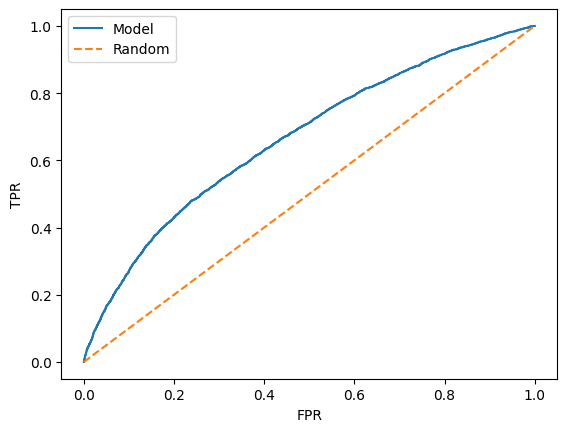

In [145]:
y_pred = clf.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred) 

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()

### K-Fold Validation to check regularization parameter

In [162]:
n_splits = 5

res = []

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        X_train = df_full_train.iloc[train_idx].drop('readmitted', axis=1)
        X_val = df_full_train.iloc[val_idx].drop('readmitted', axis=1)

        y_train = df_full_train.iloc[train_idx].readmitted
        y_val = df_full_train.iloc[val_idx].readmitted

        clf = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', LogisticRegression(solver='lbfgs', C=C, random_state=1, max_iter=500))
            ]
        )
        
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        res.append({'C': C, 'auc': auc})

  0%|          | 0/7 [00:00<?, ?it/s]

In [173]:
df_res = pd.DataFrame.from_records(res)

df_res.groupby('C').agg([np.mean, np.std]).reset_index().sort_values([('auc', 'mean'), ('auc', 'std')], ascending=[True, False])

C       auc          
               mean       std
0   0.001  0.656988  0.006571
6  10.000  0.657522  0.006685
5   5.000  0.657522  0.006680
4   1.000  0.657525  0.006679
3   0.500  0.657531  0.006675
2   0.100  0.657556  0.006643
1   0.010  0.657751  0.006540

### RandomForest

In [183]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical),
    ]
)



In [196]:
scores = []

ds = range(20, 35, 5)

for d in tqdm(ds):
    for n in tqdm(range(10, 201, 10)):
        rf = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                (
                    'classifier',
                    RandomForestClassifier(
                        n_estimators=n,
                        max_depth=d,
                        random_state=1,
                        n_jobs=-1
                    )
                )
            ]
        )

        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

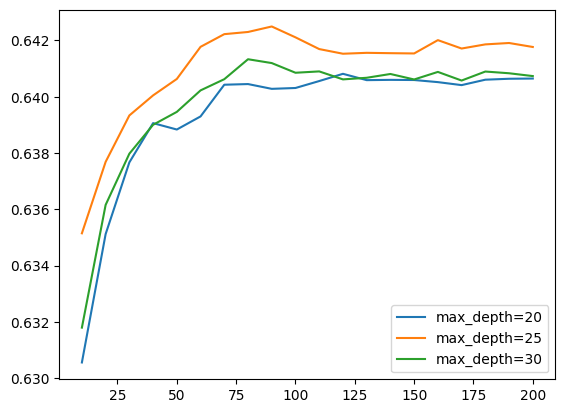

In [197]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

for d in ds:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()
plt.show()

In [198]:
max_depth = 25

In [200]:
scores = []

for s in tqdm([1, 3, 5, 10, 50]):
    for n in tqdm(range(10, 201, 10)):
        rf = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                (
                    'classifier',
                    RandomForestClassifier(
                        n_estimators=n,
                        max_depth=max_depth,
                        min_samples_leaf=s,
                        random_state=1,
                        n_jobs=-1
                    )
                )
            ]
        )

        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

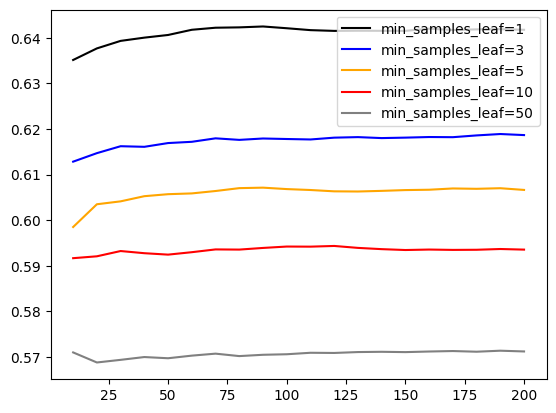

In [203]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()
plt.show()

Other useful features:
* max_features
* bootstrap